# Two-compartment spiking neurons on MNIST

This notebook explores how **two-compartment spiking neurons** behave on a real vision task: handwritten digit classification with **MNIST**.

Instead of treating a neuron as a single lumped unit, we separate its inputs into:

- **Basal compartment** – main feedforward input (image pixels)
- **Apical compartment** – contextual or auxiliary input (e.g., blurred image, teacher signal, or other top-down information)

Both compartments evolve over time using a **Leaky Integrate-and-Fire (LIF)** model implemented with `snnTorch`, and the network is trained with **surrogate gradient backpropagation**.

---

## What this notebook does

1. **Load and preprocess MNIST**
   - Standard train / test split
   - Images are scaled and fed into a spiking network over multiple time steps

2. **Define a two-compartment LIF neuron**
   - Basal and apical inputs are processed separately
   - Their voltages are combined at the soma to decide when to spike
   - Spikes are accumulated over time and passed to a readout layer for classification

3. **Build a two-compartment SNN for MNIST**
   - Input: MNIST images (`28×28`)
   - Hidden layer: spiking neurons with basal + apical compartments
   - Output: 10-way classification based on spike counts

4. **Context experiments (apical as “extra information”)**
   - Apical input receives a **different view** of the image (for example, a blurred / low-resolution version)
   - The network is trained end-to-end to see whether the apical compartment actually helps, or if it gets ignored

5. **Ablation tests**
   - Evaluate the trained model under:
     - Normal conditions (basal + apical)
     - **No apical** (apical channel zeroed out)
     - **No basal** (basal channel zeroed out)
   - This shows whether the network truly relies on each compartment, and whether they play different roles.

---

The goal is not just to “get good accuracy,” but to ask:

> When we give artificial neurons a more biologically inspired structure (separate basal and apical compartments),  
> do they end up using those compartments in meaningful ways?


In [1]:
# imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from scipy.ndimage import gaussian_filter
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
# to ensure reproducibility

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)


In [3]:
!pip install snntorch
import snntorch as snn
from snntorch import surrogate


spike_grad = surrogate.fast_sigmoid()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 12.0 MB/s eta 0:00:00


## Two-compartment LIF neuron

Here we define a **two-compartment Leaky Integrate-and-Fire (LIF) neuron**.

Instead of one lumped input, each neuron has:

- A **basal compartment** that receives one input vector (e.g., pixels or features).
- An **apical compartment** that receives a *separate* input vector (e.g., context, blurred image, or teacher signal).

For each time step:

1. Basal input is projected through a weight matrix `W_basal` and added to a **basal voltage** `V_b`.
2. Apical input is projected through `W_apical` and added to an **apical voltage** `V_a`.
3. Both voltages **leak** over time (they decay if there is no input).
4. The **soma voltage** is computed as:

   > soma voltage = basal voltage + (apical_gain) × apical voltage

5. If the soma voltage crosses a threshold, the neuron emits a spike at that time step and its voltage is reset.

Because spikes are not differentiable, we use a **surrogate gradient** from `snnTorch` so we can still train this neuron with backpropagation.


In [4]:
class TwoCompartmentLIF(nn.Module):
    def __init__(self, in_basal, in_apical, hidden_size,
                 tau_b=20.0, tau_a=20.0,
                 v_th=1.0, apical_gain=0.5, v_reset=0.0):
        super().__init__()

        self.W_basal  = nn.Linear(in_basal,  hidden_size, bias=False)
        self.W_apical = nn.Linear(in_apical, hidden_size, bias=False)

        self.hidden_size = hidden_size
        self.tau_b = tau_b
        self.tau_a = tau_a
        self.v_th = v_th
        self.v_reset = v_reset
        self.apical_gain = apical_gain

        self.alpha_b = math.exp(-1.0 / self.tau_b)
        self.alpha_a = math.exp(-1.0 / self.tau_a)

    def forward(self, x_basal, x_apical):
        """
        x_basal:  [T, B, in_basal]
        x_apical: [T, B, in_apical]
        Returns:
            spikes: [T, B, hidden_size]
            V_soma: [T, B, hidden_size]
        """
        T, B, _ = x_basal.shape
        device = x_basal.device

        V_b = torch.zeros(B, self.hidden_size, device=device)
        V_a = torch.zeros(B, self.hidden_size, device=device)

        spikes = []
        Vs = []

        for t in range(T):
            xb_t = x_basal[t]   # [B, in_basal]
            xa_t = x_apical[t]  # [B, in_apical]

            I_b = self.W_basal(xb_t)   # [B,H]
            I_a = self.W_apical(xa_t)  # [B,H]

            V_b = self.alpha_b * V_b + I_b
            V_a = self.alpha_a * V_a + I_a

            V_soma = V_b + self.apical_gain * V_a

            # surrogate spike (use your existing spike_grad)
            s = spike_grad(V_soma - self.v_th)
            s_hard = (V_soma >= self.v_th).float()

            # reset on hard spikes
            V_b = torch.where(s_hard > 0, torch.full_like(V_b, self.v_reset), V_b)
            V_a = torch.where(s_hard > 0, torch.full_like(V_a, self.v_reset), V_a)

            spikes.append(s)
            Vs.append(V_soma)

        spikes = torch.stack(spikes, dim=0)
        Vs     = torch.stack(Vs, dim=0)
        return spikes, Vs


## Base two-compartment SNN for MNIST

Next, we wrap the two-compartment neuron in a full network for MNIST.

- Input: a batch of `B` images of shape `[B, 1, 28, 28]`.
- We **flatten** each image into a vector of length 784.
- We feed the same pixels into:
  - the **basal** compartment, and
  - the **apical** compartment (possibly with different masks or preprocessing in later experiments).

The network runs for `T` time steps:

- At each time step, it receives the same image as a rate-coded input.
- The two-compartment neuron produces spikes over time.
- We **sum spikes over time** for each hidden neuron.
- A final linear layer maps spike counts to **10 logits** (one per digit).

This gives us a standard spiking classifier, but with separated basal and apical inputs.


In [5]:
class TwoCompartmentMNISTNet(nn.Module):
    def __init__(self, hidden_size=256, num_classes=10, num_steps=25):
        super().__init__()
        self.num_steps = num_steps

        self.tc_lif = TwoCompartmentLIF(
            in_basal=28*28,
            in_apical=28*28,
            hidden_size=hidden_size,
            v_th=1.0,
            apical_gain=0.5    # now apical actually contributes
        )
        self.readout = nn.Linear(hidden_size, num_classes)

    def forward(self, images):
        """
        images: [B, 1, 28, 28]
        """
        B = images.size(0)
        device = images.device

        flat = images.view(B, -1)   # [B, 784]

        # split pixels into basal vs apical according to mask
        xb = flat * mask_basal      # [B, 784]
        xa = flat * mask_apical     # [B, 784]

        # repeat in time (rate code)
        xb_seq = xb.unsqueeze(0).repeat(self.num_steps, 1, 1)  # [T,B,784]
        xa_seq = xa.unsqueeze(0).repeat(self.num_steps, 1, 1)  # [T,B,784]

        spikes, _ = self.tc_lif(xb_seq, xa_seq)  # [T,B,H]
        spike_counts = spikes.sum(dim=0)         # [B,H]
        logits = self.readout(spike_counts)      # [B,10]
        return logits


In [6]:
# training loop

def train_snn(model, train_loader, test_loader, num_epochs=10, lr=1e-3, device="cuda"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_acc_hist = []
    test_acc_hist = []

    for epoch in range(num_epochs):

        model.train()
        total_correct = 0
        total_samples = 0
        total_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)   # [B, 1, 28, 28]
            labels = labels.to(device)   # [B]
            optimizer.zero_grad()
            logits = model(images)       # [B, 10]
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

        train_acc = total_correct / total_samples
        train_loss = total_loss / total_samples
        train_acc_hist.append(train_acc)
        model.eval()
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                logits = model(images)
                preds = logits.argmax(dim=1)

                total_correct += (preds == labels).sum().item()
                total_samples += labels.size(0)

        test_acc = total_correct / total_samples
        test_acc_hist.append(test_acc)

        print(
            f"Epoch {epoch:2d} | "
            f"train loss {train_loss:.4f} | "
            f"train acc {train_acc:.4f} | "
            f"test acc {test_acc:.4f}"
        )

    return train_acc_hist, test_acc_hist


## Splitting MNIST pixels into basal vs apical inputs

Getting the MNIST Dataset. Then, to give the two-compartment neuron two different input streams, we split each 28×28 MNIST image into **basal pixels** and **apical pixels**.

Implementation:

- We flatten each image into a vector of length 784.
- We randomly choose half of the indices to be **basal**.
- The remaining pixels become **apical**.

In code:

- `mask_basal = 1` means “this pixel goes to the basal compartment”.
- `mask_apical = 1` means “this pixel goes to the apical compartment”.

This way, the overall information content is the same, but the neuron has to learn how to combine **two separate spatial streams** instead of seeing all pixels in a single compartment.


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),                  # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))
])


train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)




# converting the MNIST

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.64MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.59MB/s]


In [8]:
input_dim = 28 * 28
mask = torch.zeros(input_dim)
perm = torch.randperm(input_dim)
half = input_dim // 2
mask[perm[:half]] = 1.0

mask_basal = mask          # 1 = basal pixel
mask_apical = 1.0 - mask   # 1 = apical pixel
device = "cuda" if torch.cuda.is_available() else "cpu"
mask_basal = mask_basal.to(device)
mask_apical = mask_apical.to(device)


This is a sample of what the data and the split looks like

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.66MB/s]


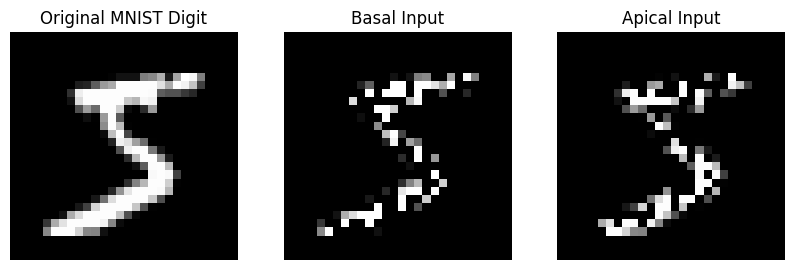

In [9]:
mnist = datasets.MNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
img, label = mnist[0]
img = img.squeeze().numpy()


np.random.seed(0)
mask_basal = np.random.rand(28, 28) > 0.5
mask_apical = ~mask_basal

fig, axs = plt.subplots(1, 3, figsize=(10,4))

axs[0].imshow(img, cmap='gray')
axs[0].set_title("Original MNIST Digit")
axs[0].axis('off')

axs[1].imshow(img * mask_basal, cmap='gray')
axs[1].set_title("Basal Input")
axs[1].axis('off')

axs[2].imshow(img * mask_apical, cmap='gray')
axs[2].set_title("Apical Input")
axs[2].axis('off')

plt.show()


### Running Training and Ablations

In [11]:
input_dim = 28 * 28
mask = torch.zeros(input_dim)
perm = torch.randperm(input_dim)
half = input_dim // 2
mask[perm[:half]] = 1.0

mask_basal = mask          # 1 = basal pixel
mask_apical = 1.0 - mask   # 1 = apical pixel
# device is already defined
mask_basal = mask_basal.to(device)
mask_apical = mask_apical.to(device)

model = TwoCompartmentMNISTNet(hidden_size=128, num_classes=10)

train_acc, test_acc = train_snn(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=4,
    lr=1e-3,
    device=device
)

Epoch  0 | train loss 0.4046 | train acc 0.8881 | test acc 0.8912
Epoch  1 | train loss 0.2490 | train acc 0.9280 | test acc 0.9417
Epoch  2 | train loss 0.2335 | train acc 0.9340 | test acc 0.9428
Epoch  3 | train loss 0.2299 | train acc 0.9338 | test acc 0.9182


In [12]:
def eval_model(model, loader, ablate_apical=False, ablate_basal=False):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            B = images.size(0)
            flat = images.view(B, -1)

            # use same masks as in training
            xb = flat * mask_basal
            xa = flat * mask_apical

            if ablate_apical:
                xa = torch.zeros_like(xa)
            if ablate_basal:
                xb = torch.zeros_like(xb)

            xb_seq = xb.unsqueeze(0).repeat(model.num_steps, 1, 1)
            xa_seq = xa.unsqueeze(0).repeat(model.num_steps, 1, 1)

            spikes, _ = model.tc_lif(xb_seq, xa_seq)
            spike_counts = spikes.sum(dim=0)
            logits = model.readout(spike_counts)

            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    return correct / total


In [13]:
acc_full     = eval_model(model, test_loader)
acc_no_ap    = eval_model(model, test_loader, ablate_apical=True)
acc_no_basal = eval_model(model, test_loader, ablate_basal=True)
print("Test acc:", acc_full)
print("Test acc WITHOUT apical input:", acc_no_ap)
print("Test acc WITHOUT basal input:", acc_no_basal)


Test acc: 0.9181690705128205
Test acc WITHOUT apical input: 0.9063501602564102
Test acc WITHOUT basal input: 0.8118990384615384


Based on the ablations above, the model relies on both inputs to get the full 0.93 accuracy since ablations cause a drop in accuracy.

## Experiment: blurred image as apical “context”

In the next experiment, the two compartments get **different versions** of the same digit:

- **Basal compartment**: full-resolution 28×28 MNIST image.
- **Apical compartment**: a **blurred / low-resolution** version of the image.

Implementation details:

- We use `AvgPool2d` to downsample 28×28 → 7×7.
- Then we upsample back to 28×28 with bilinear interpolation.
- The result keeps the **global shape** but loses most of the fine detail.

Idea:

- Basal sees sharp edges and local detail.
- Apical sees a coarse, global view that plays the role of **top-down context**.

We then train the model and compare:

- Test accuracy **with** blurred apical context.
- Test accuracy when apical input is replaced by zeros.

If removing the blurred apical input hurts performance, it suggests that the apical compartment is actively using this contextual signal. Below is an example of the data


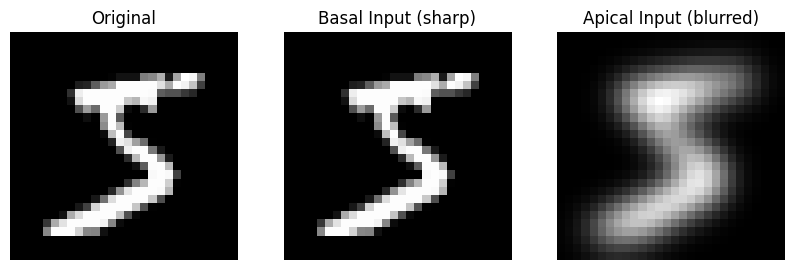

In [14]:
# Load MNIST image
mnist = datasets.MNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
img, label = mnist[0]
img = img.squeeze().numpy()

# Basal = original
basal = img

# Apical = blurred version
apical = gaussian_filter(img, sigma=2)   # adjust sigma to control blur strength

plt.figure(figsize=(10,4))

# Original
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

# Basal input
plt.subplot(1,3,2)
plt.imshow(basal, cmap='gray')
plt.title("Basal Input (sharp)")
plt.axis('off')

# Apical input
plt.subplot(1,3,3)
plt.imshow(apical, cmap='gray')
plt.title("Apical Input (blurred)")
plt.axis('off')

plt.show()


Above is an example of this data

In [15]:


class TwoCompartmentMNISTNetBlurContext(nn.Module):
    def __init__(self, hidden_size=256, num_classes=10, num_steps=25, use_context=True):
        super().__init__()
        self.num_steps = num_steps
        self.use_context = use_context

        # two-compartment LIF: both basal and apical get 784-dim inputs
        self.tc_lif = TwoCompartmentLIF(
            in_basal=28*28,
            in_apical=28*28,
            hidden_size=hidden_size,
            v_th=1.0,
            apical_gain=0.5,   # apical actually contributes
        )
        self.readout = nn.Linear(hidden_size, num_classes)

        # simple blur / low-res context: 4x4 average pooling -> 7x7, then upsample back
        self.pool = nn.AvgPool2d(kernel_size=4, stride=4)  # 28x28 -> 7x7
        self.upsample = nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False)

    def make_context(self, images):
        """
        images: [B, 1, 28, 28]
        returns ctx_images: [B, 1, 28, 28] blurred / low-res
        """
        # downsample
        x = self.pool(images)                # [B,1,7,7]
        # upsample back to 28x28
        x = self.upsample(x)                 # [B,1,28,28]
        # (optional) normalize a bit
        # x = (x - x.mean(dim=[2,3], keepdim=True)) / (x.std(dim=[2,3], keepdim=True) + 1e-5)
        return x

    def forward(self, images):
        """
        images: [B, 1, 28, 28]
        Basal: full-res image
        Apical: blurred/low-res version of same image (if use_context=True)
        """
        B = images.size(0)
        device = images.device

        # Basal: original pixels
        xb = images.view(B, -1)  # [B, 784]

        if self.use_context:
            ctx_images = self.make_context(images)   # [B,1,28,28]
            xa = ctx_images.view(B, -1)             # [B,784]
        else:
            # no apical context -> zeros
            xa = torch.zeros_like(xb)               # [B,784]

        # repeat in time (simple rate code)
        xb_seq = xb.unsqueeze(0).repeat(self.num_steps, 1, 1)  # [T,B,784]
        xa_seq = xa.unsqueeze(0).repeat(self.num_steps, 1, 1)  # [T,B,784]

        spikes, _ = self.tc_lif(xb_seq, xa_seq)     # [T,B,H]
        spike_counts = spikes.sum(dim=0)            # [B,H]
        logits = self.readout(spike_counts)         # [B,10]
        return logits


In [16]:
# training function

def train_mnist(model, train_loader, test_loader, num_epochs=5, lr=1e-3, device="cpu"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_examples = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=-1)
            total_correct += (preds == labels).sum().item()
            total_examples += labels.size(0)

        train_loss = total_loss / total_examples
        train_acc = total_correct / total_examples

        # eval
        model.eval()
        total_correct, total_examples = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                preds = logits.argmax(dim=-1)
                total_correct += (preds == labels).sum().item()
                total_examples += labels.size(0)
        test_acc = total_correct / total_examples

        print(f"Epoch {epoch:2d} | train loss {train_loss:.4f} | "
              f"train acc {train_acc:.4f} | test acc {test_acc:.4f}")


### Running training and evaluating

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ctx = TwoCompartmentMNISTNetBlurContext(
    hidden_size=256,
    num_classes=10,
    num_steps=25,
    use_context=True,   # apical gets blurred input
).to(device)

train_mnist(model_ctx, train_loader, test_loader, num_epochs=5, lr=1e-3, device=device)


Epoch  0 | train loss 0.5130 | train acc 0.8665 | test acc 0.8914
Epoch  1 | train loss 0.3879 | train acc 0.8915 | test acc 0.8859
Epoch  2 | train loss 0.3678 | train acc 0.8990 | test acc 0.9140
Epoch  3 | train loss 0.3603 | train acc 0.9026 | test acc 0.9021
Epoch  4 | train loss 0.3491 | train acc 0.9051 | test acc 0.9077


In [18]:
def eval_model(model, test_loader, device="cpu"):
    model.eval()
    total_correct, total_examples = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=-1)
            total_correct += (preds == labels).sum().item()
            total_examples += labels.size(0)
    return total_correct / total_examples

# After training:
model_ctx.use_context = True
acc_with_ctx = eval_model(model_ctx, test_loader, device=device)

model_ctx.use_context = False
acc_no_ctx = eval_model(model_ctx, test_loader, device=device)

print("Test acc WITH blurred apical context :", acc_with_ctx)
print("Test acc WITHOUT apical context      :", acc_no_ctx)


Test acc WITH blurred apical context : 0.9076522435897436
Test acc WITHOUT apical context      : 0.9033453525641025


Unfortunately, the model does better without the context... interesting! Well, a negative result is still a result!

## Experiment: teacher network as apical feedback

Here we test a different kind of “context”: a **top-down prediction** from a separate teacher network.

1. We first train a standard ANN classifier (`TeacherNet`) on MNIST.
   - It takes pixels as input.
   - It outputs a 10-dimensional probability vector over digit classes.

2. We then build a two-compartment spiking model where:
   - **Basal** still receives the image pixels.
   - **Apical** receives a transformed version of the teacher’s output
     (for example, by repeating or projecting the 10-D probability vector).

We compare:

- Two-compartment SNN **with** teacher-based apical input.
- The same architecture with apical input set to zero.

This tests whether the network can make use of **high-level feedback** (a noisy but informative guess from the teacher) routed through the apical compartment.


### This is training the teacher model

In [19]:
class TeacherNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x: [B,1,28,28] OR [B,784]
        if x.dim() == 4:
            x = x.view(x.size(0), -1)  # [B,784]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)               # logits [B,10]
        return x

teacher = TeacherNet().to(device)

optimizer_teacher = torch.optim.Adam(teacher.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_teacher(num_epochs=3):
    teacher.train()
    for epoch in range(num_epochs):
        total_loss, total_correct, total_examples = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer_teacher.zero_grad()
            logits = teacher(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer_teacher.step()

            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=-1)
            total_correct += (preds == labels).sum().item()
            total_examples += labels.size(0)

        train_loss = total_loss / total_examples
        train_acc  = total_correct / total_examples

        # quick test eval
        teacher.eval()
        tot_corr, tot_ex = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = teacher(images)
                preds = logits.argmax(dim=-1)
                tot_corr += (preds == labels).sum().item()
                tot_ex   += labels.size(0)
        test_acc = tot_corr / tot_ex
        teacher.train()

        print(f"[Teacher] Epoch {epoch:2d} | train loss {train_loss:.4f} | "
              f"train acc {train_acc:.4f} | test acc {test_acc:.4f}")

# Train the teacher (3–5 epochs is usually plenty for MNIST)
train_teacher(num_epochs=3)

# Freeze teacher
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False


[Teacher] Epoch  0 | train loss 0.2604 | train acc 0.9232 | test acc 0.9581
[Teacher] Epoch  1 | train loss 0.1137 | train acc 0.9657 | test acc 0.9714
[Teacher] Epoch  2 | train loss 0.0775 | train acc 0.9756 | test acc 0.9735


Note that the teacher does very well -- this is a standard ANN. ANNs already do pretty well on the MNIST task, but it's still worth exploring other architectures because they might have different advantages.

In [20]:
class TwoCompartmentMNISTNetWithTeacher(nn.Module):
    def __init__(self, teacher, hidden_size=256, num_classes=10, num_steps=25):
        super().__init__()
        self.teacher = teacher
        self.num_steps = num_steps

        # Two-compartment LIF: basal=784 (pixels), apical=10 (teacher probs)
        self.tc_lif = TwoCompartmentLIF(
            in_basal=28*28,
            in_apical=10,
            hidden_size=hidden_size,
            v_th=1.0,
            apical_gain=0.5   # apical actually contributes
        )
        self.readout = nn.Linear(hidden_size, num_classes)

    def forward(self, images, use_teacher_context=True):
        """
        images: [B,1,28,28]
        """
        B = images.size(0)
        device = images.device

        # Basal: raw pixels
        flat = images.view(B, -1)                 # [B,784]
        xb_seq = flat.unsqueeze(0).repeat(self.num_steps, 1, 1)  # [T,B,784]

        # Apical: teacher belief over classes
        if use_teacher_context:
            with torch.no_grad():
                teacher_logits = self.teacher(images)            # [B,10]
                teacher_ctx = F.softmax(teacher_logits, dim=-1)  # [B,10] (or keep logits)
            xa_seq = teacher_ctx.unsqueeze(0).repeat(self.num_steps, 1, 1)  # [T,B,10]
        else:
            xa_seq = torch.zeros(self.num_steps, B, 10, device=device)

        spikes, _ = self.tc_lif(xb_seq, xa_seq)  # [T,B,H]
        spike_counts = spikes.sum(dim=0)         # [B,H]
        logits = self.readout(spike_counts)      # [B,10]
        return logits


In [21]:
def train_two_comp_with_teacher(
    model,
    train_loader,
    test_loader,
    num_epochs=5,
    lr=1e-3,
    use_context_train=True,
    use_context_test=True,
    device=device,
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # train
        model.train()
        total_loss, total_correct, total_examples = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(images, use_teacher_context=use_context_train)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=-1)
            total_correct += (preds == labels).sum().item()
            total_examples += labels.size(0)

        train_loss = total_loss / total_examples
        train_acc  = total_correct / total_examples

        # eval
        model.eval()
        tot_corr, tot_ex = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images, use_teacher_context=use_context_test)
                preds = logits.argmax(dim=-1)
                tot_corr += (preds == labels).sum().item()
                tot_ex   += labels.size(0)
        test_acc = tot_corr / tot_ex

        print(f"Epoch {epoch:2d} | train loss {train_loss:.4f} | "
              f"train acc {train_acc:.4f} | test acc {test_acc:.4f}")


### Training and evaluating the teacher/student two compartment model

In [22]:
#instantiate the two-compartment SNN with teacher context
ctx_model = TwoCompartmentMNISTNetWithTeacher(
    teacher=teacher,   # frozen teacher
    hidden_size=256,
    num_steps=25
).to(device)

print("=== Train with teacher context ON, test with context ON ===")
train_two_comp_with_teacher(
    ctx_model,
    train_loader,
    test_loader,
    num_epochs=5,
    lr=1e-3,
    use_context_train=True,
    use_context_test=True,
    device=device,
)

#evaluate SAME model with context OFF vs ON
def eval_with_context_flag(model, test_loader, use_context_test, device=device):
    model.eval()
    total_correct, total_examples = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images, use_teacher_context=use_context_test)
            preds = logits.argmax(dim=-1)
            total_correct += (preds == labels).sum().item()
            total_examples += labels.size(0)
    return total_correct / total_examples

acc_with_ctx = eval_with_context_flag(ctx_model, test_loader, use_context_test=True)
acc_no_ctx   = eval_with_context_flag(ctx_model, test_loader, use_context_test=False)

print(f"Final test acc WITH teacher context : {acc_with_ctx:.4f}")
print(f"Final test acc WITHOUT apical input : {acc_no_ctx:.4f}")


=== Train with teacher context ON, test with context ON ===
Epoch  0 | train loss 0.3748 | train acc 0.9067 | test acc 0.9094
Epoch  1 | train loss 0.2721 | train acc 0.9294 | test acc 0.9192
Epoch  2 | train loss 0.2927 | train acc 0.9274 | test acc 0.9408
Epoch  3 | train loss 0.2821 | train acc 0.9298 | test acc 0.9307
Epoch  4 | train loss 0.2823 | train acc 0.9316 | test acc 0.9184
Final test acc WITH teacher context : 0.9184
Final test acc WITHOUT apical input : 0.8760


In this case, the model does better with the context. However, this is not suprising since the context signal is coming from a very strong model. Still this setup shows that strong context and help the SNN.

### Overall conclusions

- Two-compartment spiking neurons **do** change how the network processes information:
  - Basal and apical inputs are used in **non-redundant** ways.
  - Context-like signals (e.g. teacher predictions) routed through apical dendrites can influence performance and robustness.

- However, on MNIST:
  - A two-compartment SNN **does not automatically beat** a well-trained ANN.
  - This matches the intuition that **one biological feature** (compartments) is not enough on its own to recreate the full power of the brain.

- In the brain, compartments interact with:
  - Nonlinear dendritic integration,
  - Inhibition and gating,
  - Local learning rules,
  - Multiple timescales and circuits.

... ideas for future projects :)